In [1]:
import os
import pandas as pd
import numpy as np

import nilearn as nl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans

In [2]:
X_features = np.load("features.npz")['a']
print("Feature file found.")

print("Running PCA...")
pca = PCA(0.99).fit(X_features)
X_features_pca = pca.transform(X_features)

Feature file found.
Running PCA...


In [3]:
y_target = np.load("labels.npz")['a']

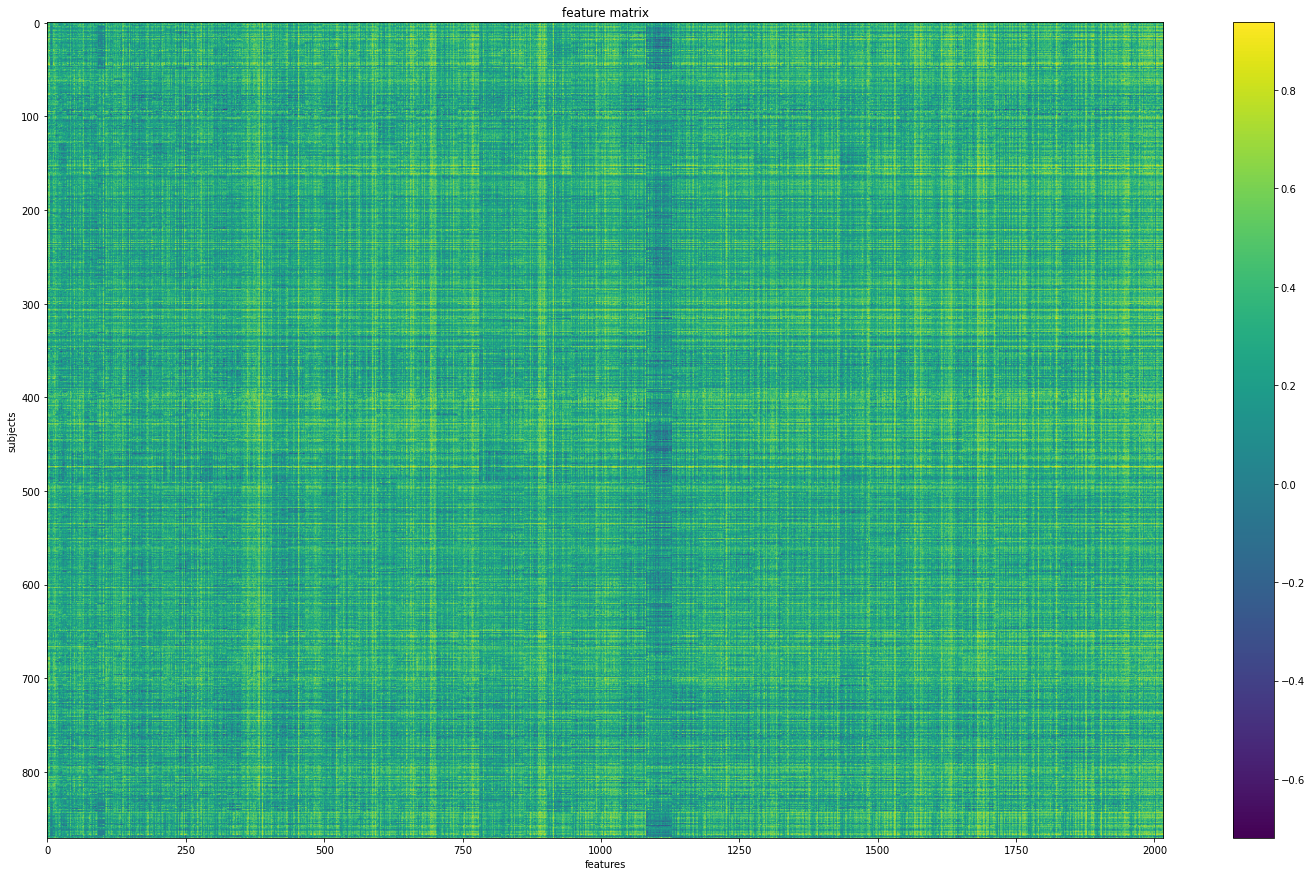

In [4]:
plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

plt.gcf().set_size_inches(25, 15)

In [5]:
#Define functions to compute accuracy mean and std 

def compute_acc_std_mean (train_scores, test_scores):
    #train scores
    train_scores_mean= np.mean(train_scores, axis=1)
    train_scores_std= np.std(train_scores, axis=1)
    
    #test scores
    test_scores_mean= np.mean(test_scores, axis=1)
    test_scores_std= np.std(test_scores, axis=1)
    
    return train_scores_mean, train_scores_std, test_scores_mean, test_scores_std

In [6]:
#Define function to plot validation curve

def plot_validationcurve (param, param_range, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std):
    plt.title("Validation Curve")
    plt.xlabel("Hyperparameter : {}".format(param))
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw=2
    #plot train scores
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    #plot test scores
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    
    plt.legend(loc="best")
    plt.gcf().set_size_inches(25, 15)
    
    return plt.show()

In [7]:
# Function returning the best estimator

def best_estimator(model, param_grid, X, y, cv):
    grid = GridSearchCV (model, param_grid, cv=cv, probability=True)
    grid.fit(X, y)
    model_best= grid.best_estimator_
    param_best= grid.best_params_
    
    return model_best , param_best

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_features, y_target, test_size=0.20, shuffle = True, # shuffle dataset
stratify = y_target)

In [9]:
model_SVC = SVC()

In [10]:
param_range_SVM= np.logspace (-6, 2 , 20)

train_scores_SVM, test_scores_SVM= validation_curve(
    SVC(), X_features, y_target, param_name="gamma", param_range=param_range_SVM,
    scoring="accuracy", n_jobs=1)

In [11]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_SVM, test_scores_SVM)

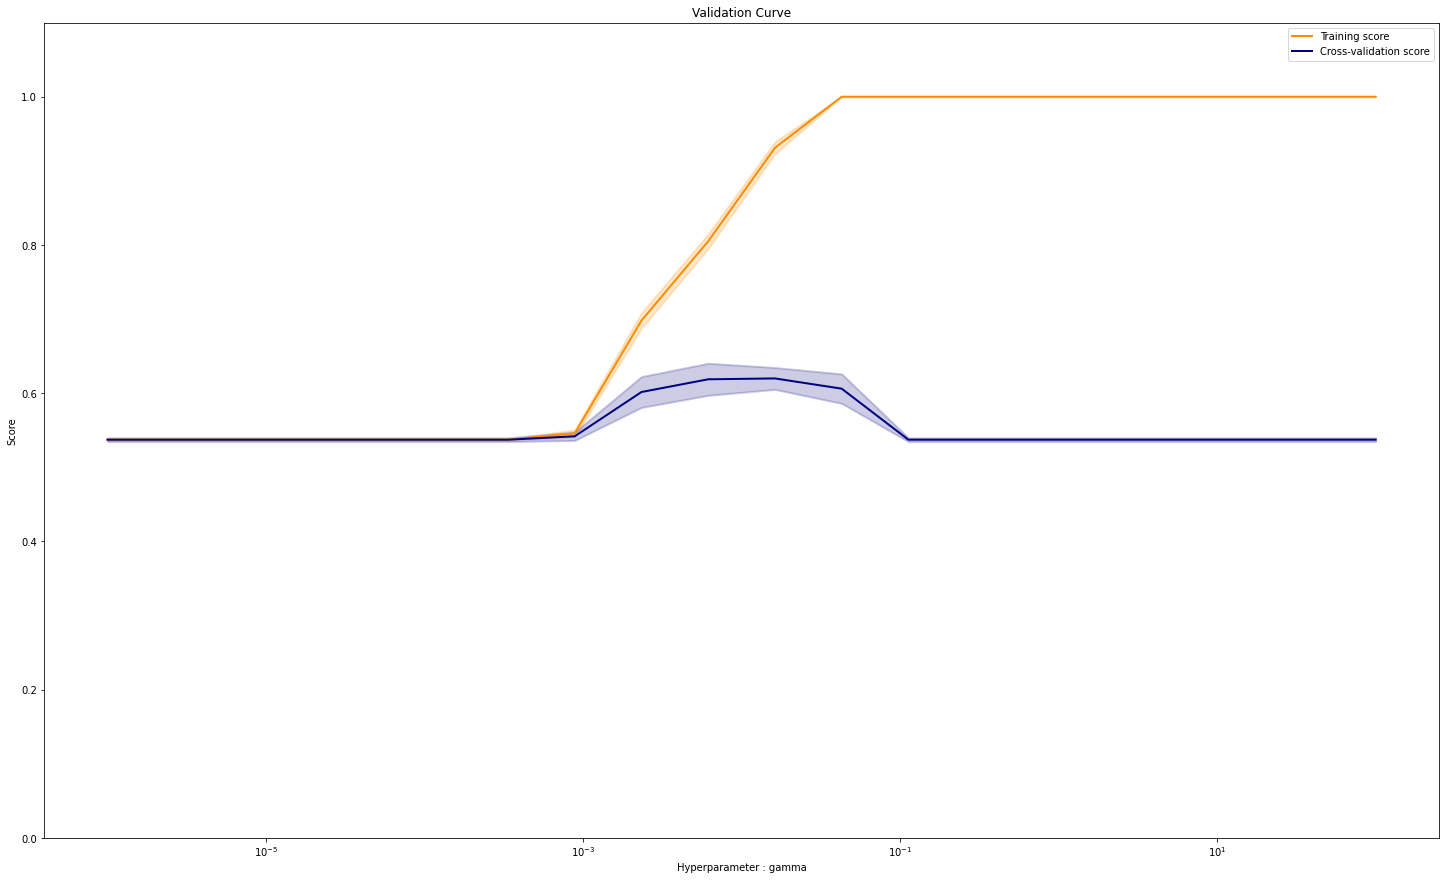

In [12]:
plot_validationcurve("gamma", param_range_SVM, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [13]:
train_scores_C, test_scores_C= validation_curve(
    SVC(), X_features, y_target, param_name="C", param_range=param_range_SVM,
    scoring="accuracy", n_jobs=1)

In [14]:
train_scores_mean, train_scores_std, test_scores_mean, test_scores_std= compute_acc_std_mean (train_scores_C, test_scores_C)

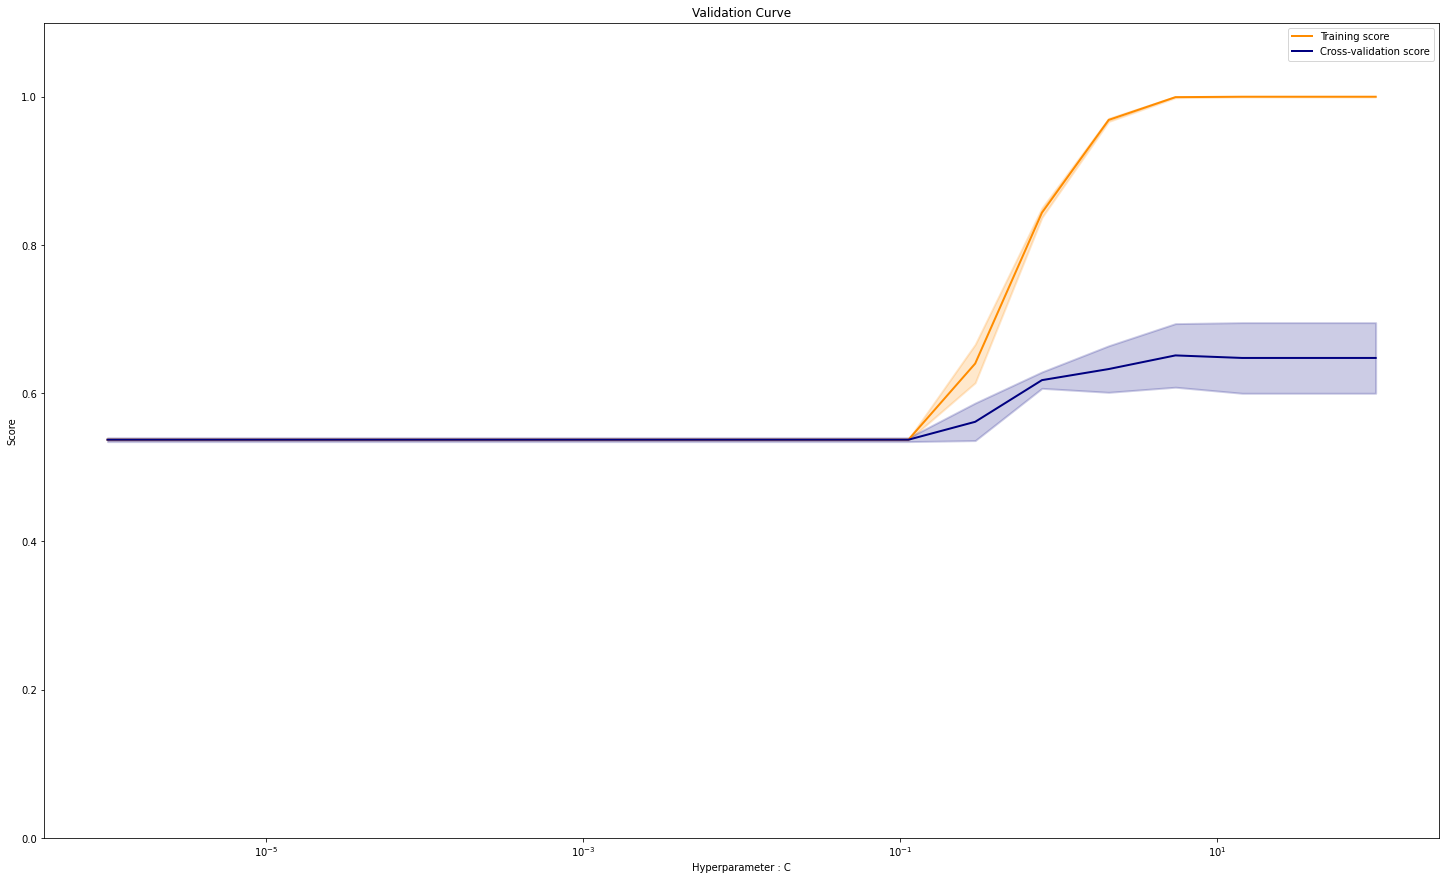

In [15]:
plot_validationcurve("C", param_range_SVM, train_scores_mean, train_scores_std, 
                          test_scores_mean, test_scores_std)

In [16]:
#model.get_params().keys()

param_grid_SVC = {'C': [0.01, 0.1, 1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4,  5, 10],
              'gamma': [0.00001, 0.00005,  0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 3.5, 5, 10]}

best_estimator(model_SVC, param_grid_SVC, X_features, y_target, 10)

TypeError: __init__() got an unexpected keyword argument 'probability'

In [17]:
model_best = SVC(C=10, gamma=0.001, kernel='rbf')

In [29]:
score_kfold=cross_val_score(model_best, X_features, y_target, cv=10).mean() #cv is the number of folds
print(score_kfold.mean())

0.6600835945663532


In [23]:
from sklearn.model_selection import KFold, cross_val_score 

k_folds = KFold(n_splits = 5)

scores = cross_val_score(model_best, X_features, y_target, cv = k_folds) 
print("Average CV Score: ", scores.mean())

Average CV Score:  0.6302660098522168


In [24]:
model_best.fit(X_features, y_target)

SVC(C=10, gamma=0.001)

c:\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


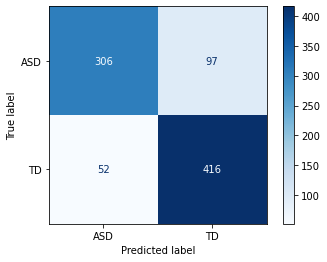

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_best,
                      X_features, y_target,
                      values_format='d',
                      display_labels=["ASD","TD"], cmap="Blues")